# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Regressão-Linear" data-toc-modified-id="Regressão-Linear-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Regressão Linear</a></div><div class="lev2 toc-item"><a href="#Importação-dos-módulos" data-toc-modified-id="Importação-dos-módulos-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Importação dos módulos</a></div><div class="lev2 toc-item"><a href="#Conjunto-de-dados:-Flôres-Íris" data-toc-modified-id="Conjunto-de-dados:-Flôres-Íris-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Conjunto de dados: Flôres Íris</a></div><div class="lev2 toc-item"><a href="#Dados:-leitura-e-visualização" data-toc-modified-id="Dados:-leitura-e-visualização-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Dados: leitura e visualização</a></div><div class="lev2 toc-item"><a href="#Visualização-dos-dados-x-e-y" data-toc-modified-id="Visualização-dos-dados-x-e-y-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Visualização dos dados <code>x</code> e <code>y</code></a></div><div class="lev2 toc-item"><a href="#Estabilidade-numérica" data-toc-modified-id="Estabilidade-numérica-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Estabilidade numérica</a></div><div class="lev2 toc-item"><a href="#Normalização-dos-dados-entre-0-e-1" data-toc-modified-id="Normalização-dos-dados-entre-0-e-1-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Normalização dos dados entre 0 e 1</a></div><div class="lev2 toc-item"><a href="#Visualização-dos-dados-normalizados" data-toc-modified-id="Visualização-dos-dados-normalizados-17"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Visualização dos dados normalizados</a></div><div class="lev2 toc-item"><a href="#Reta-de-ajuste" data-toc-modified-id="Reta-de-ajuste-18"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Reta de ajuste</a></div><div class="lev2 toc-item"><a href="#Representação-gráfica-da-equação-linear-via-neurônio" data-toc-modified-id="Representação-gráfica-da-equação-linear-via-neurônio-19"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Representação gráfica da equação linear via neurônio</a></div><div class="lev2 toc-item"><a href="#Programação-Matricial" data-toc-modified-id="Programação-Matricial-110"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>Programação Matricial</a></div><div class="lev2 toc-item"><a href="#Representação-matricial-da-equação-linear" data-toc-modified-id="Representação-matricial-da-equação-linear-111"><span class="toc-item-num">1.11&nbsp;&nbsp;</span>Representação matricial da equação linear</a></div><div class="lev2 toc-item"><a href="#Aumento-da-dimensionalidade-do-problema" data-toc-modified-id="Aumento-da-dimensionalidade-do-problema-112"><span class="toc-item-num">1.12&nbsp;&nbsp;</span>Aumento da dimensionalidade do problema</a></div><div class="lev2 toc-item"><a href="#Representação-gráfica-rede-neural" data-toc-modified-id="Representação-gráfica-rede-neural-113"><span class="toc-item-num">1.13&nbsp;&nbsp;</span>Representação gráfica rede neural</a></div><div class="lev2 toc-item"><a href="#Formulação-do-problema-do-ajuste-da-reta-como-um-problema-de-minimização" data-toc-modified-id="Formulação-do-problema-do-ajuste-da-reta-como-um-problema-de-minimização-114"><span class="toc-item-num">1.14&nbsp;&nbsp;</span>Formulação do problema do ajuste da reta como um problema de minimização</a></div><div class="lev2 toc-item"><a href="#Minimização-via-Gradiente-Descendente" data-toc-modified-id="Minimização-via-Gradiente-Descendente-115"><span class="toc-item-num">1.15&nbsp;&nbsp;</span>Minimização via Gradiente Descendente</a></div><div class="lev2 toc-item"><a href="#Laço-de-minimização-via-gradiente-descendente" data-toc-modified-id="Laço-de-minimização-via-gradiente-descendente-116"><span class="toc-item-num">1.16&nbsp;&nbsp;</span>Laço de minimização via gradiente descendente</a></div><div class="lev2 toc-item"><a href="#Comparando-com-a-solução-analítica" data-toc-modified-id="Comparando-com-a-solução-analítica-117"><span class="toc-item-num">1.17&nbsp;&nbsp;</span>Comparando com a solução analítica</a></div><div class="lev2 toc-item"><a href="#Plotagem-da-reta-de-predição-(solução-analítica-e-solução-via-gradiente-descendente)" data-toc-modified-id="Plotagem-da-reta-de-predição-(solução-analítica-e-solução-via-gradiente-descendente)-118"><span class="toc-item-num">1.18&nbsp;&nbsp;</span>Plotagem da reta de predição (solução analítica e solução via gradiente descendente)</a></div><div class="lev2 toc-item"><a href="#Plotagem-das-retas-durante-o-processo-de-minimização" data-toc-modified-id="Plotagem-das-retas-durante-o-processo-de-minimização-119"><span class="toc-item-num">1.19&nbsp;&nbsp;</span>Plotagem das retas durante o processo de minimização</a></div><div class="lev2 toc-item"><a href="#Visualização-do-espaço-de-parâmetros" data-toc-modified-id="Visualização-do-espaço-de-parâmetros-120"><span class="toc-item-num">1.20&nbsp;&nbsp;</span>Visualização do espaço de parâmetros</a></div><div class="lev2 toc-item"><a href="#Visualização-da-Perda-x-Parâmetros-w0,w1-em-gráfico-3D" data-toc-modified-id="Visualização-da-Perda-x-Parâmetros-w0,w1-em-gráfico-3D-121"><span class="toc-item-num">1.21&nbsp;&nbsp;</span>Visualização da Perda x Parâmetros w0,w1 em gráfico 3D</a></div><div class="lev2 toc-item"><a href="#Fazendo-no-Keras" data-toc-modified-id="Fazendo-no-Keras-122"><span class="toc-item-num">1.22&nbsp;&nbsp;</span>Fazendo no Keras</a></div><div class="lev3 toc-item"><a href="#Modelo-sequencial" data-toc-modified-id="Modelo-sequencial-1221"><span class="toc-item-num">1.22.1&nbsp;&nbsp;</span>Modelo sequencial</a></div><div class="lev3 toc-item"><a href="#Configurando-método-de-otimização-e-compilando-código-para-o-treinamento" data-toc-modified-id="Configurando-método-de-otimização-e-compilando-código-para-o-treinamento-1222"><span class="toc-item-num">1.22.2&nbsp;&nbsp;</span>Configurando método de otimização e compilando código para o treinamento</a></div><div class="lev3 toc-item"><a href="#Treinamento---batch-gradient-descent" data-toc-modified-id="Treinamento---batch-gradient-descent-1223"><span class="toc-item-num">1.22.3&nbsp;&nbsp;</span>Treinamento - batch gradient descent</a></div><div class="lev2 toc-item"><a href="#Sugestões-de-atividades" data-toc-modified-id="Sugestões-de-atividades-123"><span class="toc-item-num">1.23&nbsp;&nbsp;</span>Sugestões de atividades</a></div><div class="lev2 toc-item"><a href="#Conclusões-desse-experimento" data-toc-modified-id="Conclusões-desse-experimento-124"><span class="toc-item-num">1.24&nbsp;&nbsp;</span>Conclusões desse experimento</a></div><div class="lev2 toc-item"><a href="#Referências" data-toc-modified-id="Referências-125"><span class="toc-item-num">1.25&nbsp;&nbsp;</span>Referências</a></div>

# Regressão Linear

O objetivo deste notebook é:

* introduzir os conceitos básicos iniciais de redes neurais através da 
* otimização de um ajuste de pontos por uma reta (linear) utilizando a 
* técnica de cálculo numérico do gradiente descendente. 

É introduzido também:

* o uso de matrizes tanto como 
    * notação matemática como 
    * forma de programação. 

Este notebook contém:
* primeiros programas matriciais, 
* laço de otimização e 
* plotagem de gráficos.


## Importação dos módulos

O objetivo deste exercício é utilizar apenas as funções do NumPy para o processamento numérico. Iremos precisar entretanto de dois outros pacotes para:

* NumPy: Pacote Numérico do Python - é o que faz o Python ser melhor que o MATLAB
* matplotlib: ferramentas para plotagem de gráficos e imagens
* sklearn: Excelente pacote de "Aprendizagem de Máquina", aqui será usado apenas para carregar o dataset Iris
* pandas: ferramentas de formatação e visualização de dados em forma de tabelas

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

O problema de ajuste de uma reta a um conjunto de pontos para verificar se existe uma previsão linear é um problema muito antigo, muito estudado e muito presente nos dias de hoje. 

Quando o ajuste é abordado como um problema de **otimização numétrica**, ele é a base de boa parte dos **conceitos sobre redes neurais** e iremos explorá-lo aqui como uma forma de introdução às redes neurais.

## Conjunto de dados: Flôres Íris

Iremos utilizar duas propriedades do conjunto de dados das flores Íris [Wikipedia-Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set):

* o comprimento das sépalas e 
* o comprimento da pétalas. 

A ideia será prever o comprimento da pétala, conhecendo-se o comprimento da sépala. Estaremos usando apenas uma propriedade, ou característica ou *feature* do objeto para que seja fácil visualizar o espaço de busca de parâmetros. 

Vamos utilizar as 50 amostras da variedade versicolor.

![](../figures/iris_petals_sepals.png)

## Dados: leitura e visualização

O carregamento dos dados é feito pelo comando do pacote sklearn: `load_iris`.

In [2]:
iris = load_iris()
print(type(iris))
print('iris.data:',iris.data.shape,iris.data.dtype,iris.data.min(),iris.data.max())
print('iris.target:',iris.target.shape,iris.target.dtype,iris.target.min(),iris.target.max())
#print(iris.DESCR)
print('iris.features_name:',iris.feature_names)
print('iris.target_names:',iris.target_names)

iris_pd = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_pd['target'] = iris.target
iris_pd


<class 'sklearn.datasets.base.Bunch'>
iris.data: (150, 4) float64 0.1 7.9
iris.target: (150,) int64 0 2
iris.features_name: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
iris.target_names: ['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


 Iremos utilizar apenas duas informações da variedade versicolor (classe 1): 

* x: comprimento das sépalas,
* y: comprimento das pétalas.

Imprimimos o *shape* dos *arrays* `x` e `y`. O *shape* indica as dimensões do array. Neste caso, observe que possui apenas uma dimensão com 50 elementos cada. 

`x` e `y` são portanto dois arrays unidimensionais com 50 elementos cada, que são o número de amostras da variedade versicolor.

Imprimimos também, a título ilustrativo estes dois vetores:

In [3]:
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x = data[:,0]
y = data[:,1]

print('x.shape:',x.shape, x.dtype)
print('y.shape:',y.shape, y.dtype)

print('x:', x)
print('y:', y)

x.shape: (50,) float64
y.shape: (50,) float64
x: [ 7.   6.4  6.9  5.5  6.5  5.7  6.3  4.9  6.6  5.2  5.   5.9  6.   6.1  5.6
  6.7  5.6  5.8  6.2  5.6  5.9  6.1  6.3  6.1  6.4  6.6  6.8  6.7  6.   5.7
  5.5  5.5  5.8  6.   5.4  6.   6.7  6.3  5.6  5.5  5.5  6.1  5.8  5.   5.6
  5.7  5.7  6.2  5.1  5.7]
y: [ 4.7  4.5  4.9  4.   4.6  4.5  4.7  3.3  4.6  3.9  3.5  4.2  4.   4.7  3.6
  4.4  4.5  4.1  4.5  3.9  4.8  4.   4.9  4.7  4.3  4.4  4.8  5.   4.5  3.5
  3.8  3.7  3.9  5.1  4.5  4.5  4.7  4.4  4.1  4.   4.4  4.6  4.   3.3  4.2
  4.2  4.2  4.3  3.   4.1]


## Visualização dos dados `x` e `y`

A visualização das amostras é feita com o matplotlib, neste caso utilizando o `scatter`:

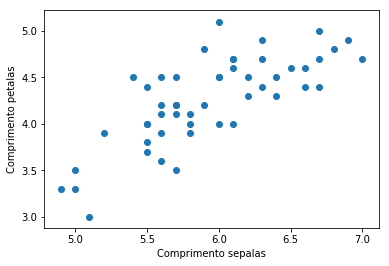

In [4]:
plt.scatter(x, y)
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')
plt.show()

## Estabilidade numérica

Em cálculo numérico trabalhamos com números representados em ponto flutuante com um número limitado de bits. Operações de valores muito grandes com valores muito baixos podem gerar resultados errados. Veja estes dois exemplos a seguir. No primeiro caso, faço uma soma acumulada começando de 1 de um pequeno valor `dx`. No segundo caso, faço uma soma acumulada começando de 1e10 do mesmo pequeno valor `dx`. No final, subtraio o valor acumulado pelo laço para que o resultado dê zero nos dois casos. Veja que no segundo caso, o erro é quase 1.


In [5]:
dz = 1e-6
n = 1000000

# Primeiro caso, somo pequeno valor a 1
z = 1.
for i in range(n):
    z = z + dz
print('Erro:', z - 2.)

# Segundo caso, somo pequeno valor a 1e10
z = 1e10
for i in range(n):
    z = z + dz
print('Erro:', z - (1+1e10))

Erro: -8.22666379463044e-11
Erro: 0.9073486328125


## Normalização dos dados entre 0 e 1

A equação da normalização dos dados para que o resultado fique entre 0 e 1 é:

$$ y = \frac{x - x_{min}}{x_{max}-x_{min}} $$

Uma forma usual sequencial de fazer esta operação de forma um pouco mais eficiente é:

$$ xx = x - x_{min} \\
   y = \frac{xx}{xx_{max}} $$

Desta forma é usual implementar a normalização através de uma subtração *in place* do mínimo e depois uma divisão também *in place* pelo máximo:

In [6]:
x -= x.min()
x /= x.max()    # normalização
y -= y.min()
y /= y.max()

#y = 2*x        # útil para verificar se o programa está funcionando (como exercício)

## Visualização dos dados normalizados


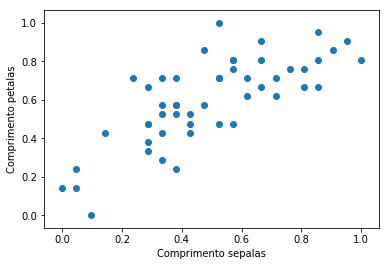

In [7]:
plt.scatter(x, y)
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')
plt.show()

## Reta de ajuste

A equação da reta no plano necessita de dois parâmetros, aqui denominados $w_0$ (*bias*) e inclinação $w_1$. Veja figura:


<img src="../figures/linhareta.png", width=300pt>

A reta de ajuste será dada por:

$$ \hat{y} = w_0 + w_1 x $$

onde 
* $w_1$ é o coeficiente angular da reta e 
* $w_0$ é a interseção do eixo vertical quando x é igual a zero, também denominado de *bias*.
* $x$ é a variável de entrada (comprimento das sépalas) e 
* $\hat{y}$ é a predição (comprimento estimado das pétalas).

## Representação gráfica da equação linear via neurônio

$ \hat{y} = 1 w_0 + x_0 w_1 $

Temos:
- 1 atributo de entrada: $x_0$
- 2 parâmetros para serem ajustados (treinados) $w_0$ e $w_1$
- 1 classe de saída $\hat{y}$

<img src="../figures/RegressaoLinearNeuronio.png", width=300pt>

## Programação Matricial

Como iremos trabalhar com várias amostras, dezenas, centenas, milhares, centenas de milhares, é mais eficiente trabalhar com vetores, matrizes e *arrays* por ser uma forma muito mais eficiente de se programar e de se processar. 

Talvez essa seja uma das **principais dificuldades** de programadores de linguagens "estilo C" onde é usual o uso de laços explícitos nos cálculos. 

Neste curso iremos usar intensivamente o NumPy que é o pacote de *arrays* numéricos que permitem programação matricial de forma muito eficiente.

## Representação matricial da equação linear

Supondo que temos $n$ amostras, as equações para todas as amostram ficam:

$$ \begin{bmatrix}
\hat{y}_0\\ 
\hat{y}_1\\
\\
\hat{y}_{n-1}  \end{bmatrix} = \begin{bmatrix}
w_0 &+& x_0 w_1\\ 
w_0 &+& x_1 w_1\\
\\ 
w_0 &+& x_{n-1} w_1\\ 
\end{bmatrix} $$

Para facilitar a conversão matricial dos dois parâmetros da reta: $ w_0$ e $w_1 $, é usual fazer as seguintes transformações:

$$ \begin{bmatrix}
\hat{y}_0\\ 
\hat{y}_1\\
\\
\hat{y}_{n-1}  \end{bmatrix} = \begin{bmatrix}
1\ w_0&+&x_0 w_1\\ 
1\ w_0&+&x_1 w_1\\
\\ 
1\ w_0&+&x_{n-1}  w_1\\ 
\end{bmatrix} $$

que é equivalente à operação matricial:

$$ \begin{bmatrix}
\hat{y}_0\\ 
\hat{y}_1\\
\\
\hat{y}_{n-1} 
\end{bmatrix} = \begin{bmatrix}
1 & x_0 \\ 
1 & x_1\\
\\ 
1 & x_{n-1} \\ 
\end{bmatrix}\begin{bmatrix}
w_0\\ 
w_1
\end{bmatrix} $$

Em notação matricial, iremos usar a convenção de representar vetores em negritos e letras minúsculas,
enquanto que matrizes iremos representar por letras maiúsculas em negrito. Assim:

$$ \boldsymbol{\hat{y}} = \boldsymbol{X} \boldsymbol{w} $$.

A multiplicação entre matrizes e entre matriz e vetor é implementada em 
Python/Numpy usando o operador `dot`. 
Temos duas notações principais:  
* `X.dot(w)` ou 
* `np.dot(X,w)`. 

As matrizes são caracterizadas pelas suas dimensões que no NumPy são denominados
* `shape` que para matrizes é organizado em 
* `(linhas, colunas)`. 
Para vetores, o `shape` contém apenas uma dimensão: 
* `(n,)`

Na multiplicação $\boldsymbol{X} \boldsymbol{w}$, 
* `X.shape=(n,2)` e 
* `W.shape=(2,)`, cujo resultado da multiplicação será 
* `(n,2)(2,)->(n,)` que é shape do vetor $\boldsymbol{\hat{y}}$.

**Dica:** Operações matriciais tornam o código conciso, escalável e simples, porém, é comum aparecer erros nestas operações e uma das melhores formas de se depurar um programa matricial é verificando
as dimensões das matrizes e vetores em uso.

## Aumento da dimensionalidade do problema

Uma das principais vantagens da representação matricial acima é a facilidade de aumento da
dimensionalidade do problema, sem mudança da equação matricial e consequentemente sem
mudança do código do programa. 

Se no problema da estimativa da largura da pétula, quisermos
utilizar não apenas uma variável de entrada, mas $k$ atributos, as únicas modificações necessárias são
mudar o número de colunas da matriz $\boldsymbol{X}$ e número de elementos do vetor de parâmetros $\boldsymbol{w}$:

$$\begin{bmatrix}
\hat{y}_0\\ 
\hat{y}_1\\
\vdots \\
\hat{y}_{n-1}
\end{bmatrix} = \begin{bmatrix}
1 & x_{0,1} & x_{0,2} & \ldots & x_{0,k} \\ 
1 & x_{1,1} & x_{1,2} & \ldots & x_{1,k}\\
\vdots & \vdots & \vdots & &\vdots\\ 
1 & x_{n-1,1} & x_{n-1,2} & \ldots & x_{n-1,k} 
\end{bmatrix}\begin{bmatrix}
w_0 \\ 
w_1 \\
\vdots \\
w_{k}
\end{bmatrix}$$

Observe as dimensões na multiplicação $\boldsymbol{y}=\boldsymbol{X} \boldsymbol{w}$: 
* $\boldsymbol{X}$: matrix de entrada: $n$ linhas (amostras) por $k+1$ colunas ($k$ atributos)
* $\boldsymbol{w}$: vetor com $k$ parâmetros + 1 (bias)
* $\boldsymbol{\hat{y}}$: vetor de saída com a predição de $n$ amostras

$$ \begin{matrix}
\boldsymbol{\hat{y}} & = & \boldsymbol{X} & \boldsymbol{w}\\
(n,) & & (n,k+1) & (k+1,) \\
\end{matrix}
$$


## Representação gráfica rede neural

O neurônio associado à regressão linear com $k$ parâmetros pode ser representado conforme a figura
a seguir. Observe que na representação do neurônio, é visualizado apenas o processamento de apenas
uma amostra, enquanto que na representação matricial, a matriz $\boldsymbol{X}$ e o vetor $\boldsymbol{\hat{y}}$ contém $n$ amostras de modo que a multiplicação matricial processa $n$ amostras
simultaneamente.

<img src="../figures/RegressaoLinearNeuronio_k.png",width=300pt>

## Formulação do problema do ajuste da reta como um problema de minimização

Dado um conjunto de $n$ pontos **rotulados** $(x_i,y_i)$ (conjunto de treinamento), 
queremos encontrar uma equação linear de predição do valor de $y$ dado um $x$ desconhecido. 
A equação da predição $\hat{y}$, na forma:

* $ \hat{y} = w_0 + w_1\ x $ 

deve ter seus parâmetros $w_0$ e $w_1$ escolhidos de modo que o erro médio quadrático

* $ \sum (\hat{y_i} - y_i)^2 $ entre as estimativas e o valor das amostras $i$ seja mínimo. 

Isto é:

$$ J(w_0,w_1) = \frac{1}{n} \sum_{i=0}^{n-1} ((w_0 + w_1\ x_i) - y_i)^2 $$ seja mínimo.

Em notação matricial:

$$ J(\boldsymbol{w})=\frac{1}{n}(\boldsymbol{X}\boldsymbol{w}−\boldsymbol{y})^T(\boldsymbol{X}\boldsymbol{w}−\boldsymbol{y}) $$

A seguir é mostrado uma implementação matricial desta função:



In [36]:
def compute_cost(X_b, y, w):
    '''
    Compute cost for linear regression
    (X,y): amostras rotuladas X(n,2) e y(n,)
    w: vetor de parâmetros
       aceita tanto shape (2,) como (2,p)
    '''
    if w.ndim == 2:
        y = y.reshape(-1,1)
    n = y.size  # número de amostras
    e = X_b.dot(w) - y
    J = (1./n) * (e * e).sum(axis=0)
    return J

## Minimização via Gradiente Descendente

O problema então se resume em encontrar os coeficientes de $\boldsymbol{w}$ que minimizem $J(\boldsymbol{w})$ no conjunto de dados rotulados `(X,y)`. Existem várias formas de se realizar esta otimização. Para fazer uma analogia com as redes neurais, a otimização será obtida por método de cálculo numérico
conhecido como "gradiente descendente". Como o gradiente de uma função aponta sempre para os valores mais altos da função, o método do gradiente descendente consiste em atualizar o valor de $\boldsymbol{w}$ subtraindo-o proporcionalmente do gradiente, isto é, indo na direção contrária do gradiente na expectativa de que iremos encontrar valores menores.

Na equação da atualização do $\boldsymbol{w}$ a seguir, o fator $\eta$ é denominado *learning rate*. Ele é um parâmetro de ajuste fundamental para o sucesso da otimização: 

$$ \boldsymbol{w} = \boldsymbol{w} − \eta \Delta J(\boldsymbol{w}) $$

Desta forma então, calculando-se o gradiente de $J(\boldsymbol{w})$ e substituindo na equação acima temos:

$$ \boldsymbol{w} = \boldsymbol{w} − \eta \frac{1}{n}(\boldsymbol{X}^T(\boldsymbol{X}\boldsymbol{w}−\boldsymbol{y})) $$

Esta equação é implementada dentro da função `gradient_descent`.

Observe que cada atualização dos pesos, o cálculo do gradiente leva em conta todas as amostras
de dados que estão representados na matriz $\boldsymbol{X}$ que possui $n$ linhas.


In [54]:
def batch_gradient_descent(X, y, w_init, lr, num_epochs):
    '''
    Perform batch gradient descent to learn w
    by taking num_epochs gradient steps with learning
    rate lr
    Dados rotulados: X.shape:(n,2) e y.shape:(n,)
    Parâmetro inicial: w_init.shape:(2,)
    output: w_history:(2,num_epochs+1)
    '''
    n = y.size
    w = w_init
    w_history = [w_init]

    for i in range(num_epochs):
        w = w - lr * (2.0 / n) * (X.T).dot(X.dot(w) - y)
        w_history.append(w)
    return np.array(w_history).T

In [139]:
def stochastic_gradient_descent(X, y, w_init, lr, num_epochs):
    '''
    Perform stochastic gradient descent to learn w
    by taking num_epochs times number of samples 
    gradient steps with learning rate lr
    Dados rotulados: X.shape:(n,2) e y.shape:(n,)
    Parâmetro inicial: w_init.shape:(2,)
    output: w_history:(2,num_epochs+1)
    '''
    n = y.size
    w = w_init
    w_history = [w_init]

    for i in range(num_epochs):
        for jj in range(n):
            j = np.random.randint(n)
            w = w - lr * 2.0 * (X[j:j+1,:].T).dot(X[j:j+1,:].dot(w) - y[j:j+1])
            w_history.append(w)
    return np.array(w_history).T

## Laço de minimização via gradiente descendente

O código da próxima célula é a parte principal deste notebook. É aqui que a minimização é feita. É aqui que dizemos que estamos fazendo o *fit*, ou o treinamento do sistema para encontrar o parâmetro $\boldsymbol{W}$ que minimiza a função de perda $J$. Acompanhamos a convergência da minimização pelo valor da perda a cada iteração, plotando o vetor `J_history`.


O esquema da otimização é representado pelo diagrama a seguir:

![](../figures/graddesc.png)

e é implementado pela próxima célula de código:

w_optimal:
 [ 0.25380471  0.69491856]
final cost (gradiente descendente): 0.0211849992487


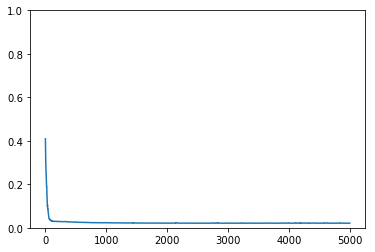

[ 0.40907029  0.38543657  0.36648838  0.34585742  0.33216891  0.31114032
  0.29578266  0.28759066  0.2697971   0.26710854]


In [140]:
# Parâmetros do gradiente descendente: número de iterações e taxa de aprendizagem
iterations = 100
lr = 0.01

n = y.size

#Montagem da matriz X agora com os elementos 1 na primeira coluna
X_bias = np.hstack([np.ones(shape=(n,1)), x.reshape(n,1)])
w_init = np.zeros(shape=(2,))

w_history = stochastic_gradient_descent(X_bias, y, w_init, lr, iterations)
#w_history = batch_gradient_descent(X_bias, y, w_init, lr, iterations)

w_optimal = w_history[:,-1] # pega o último valor do gradiente descendente
print('w_optimal:\n', w_optimal)
print('final cost (gradiente descendente):', compute_cost(X_bias, y, w_optimal))

J_history = compute_cost(X_bias, y, w_history)

# Plot da curva de minimização de J com o número de iterações
plt.plot(J_history) # mostrando log para amplificar valores baixos
plt.ylim(0,1)
plt.show()
print(J_history[:10])

## Comparando com a solução analítica

A solução analítica deste problema é dada por:

$$  \boldsymbol{w} =(\boldsymbol{X}^T \boldsymbol{X})^{−1}\boldsymbol{X}^T \boldsymbol{y} $$

In [141]:
w_opt = (np.linalg.inv((X_bias.T).dot(X_bias)).dot(X_bias.T)).dot(y)
print(w_opt)
print('final cost (analítica):', compute_cost(X_bias, y, w_opt))

[ 0.26134159  0.68646976]
final cost (analítica): 0.0211694241191


## Plotagem da reta de predição (solução analítica e solução via gradiente descendente)

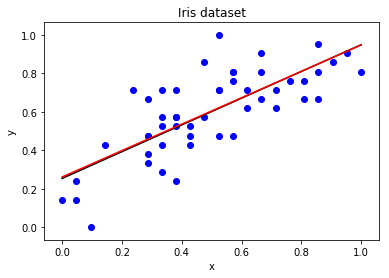

In [142]:
plt.scatter(x, y, marker='o', c='b')
plt.title('Iris dataset')
plt.xlabel('x')
plt.ylabel('y')

# Plotagem da reta utilizando os parâmetros ótimos encontrados no gradiente descendente

X_all = np.linspace(x.min(),x.max(),100).reshape(100,1)
X_all_bias = np.hstack([np.ones((100,1)),X_all])
result = X_all_bias.dot(w_optimal)  # Predição via minimização gradiente descendente
plt.plot(X_all, result, c='k')
result_opt = X_all_bias.dot(w_opt)  # Predição do valor analítico
plt.plot(X_all, result_opt,c='r')
plt.show()

## Plotagem das retas durante o processo de minimização

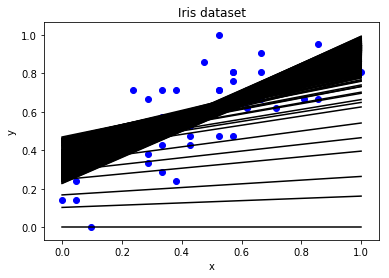

In [143]:
# Plotagem dos pontos
plt.scatter(x, y, marker='o', c='b')
plt.title('Iris dataset')
plt.xlabel('x')
plt.ylabel('y')

for w in w_history[:,::iterations//10].T: # 10 parâmetros durante minimização
    result = X_all_bias.dot(w)  # Predição
    plt.plot(X_all, result, c='k')
plt.show();

## Visualização do espaço de parâmetros

Como o problema de ajuste de uma reta em pontos bidimensionais precisam da sintonia ou treinamento ou otimização de apenas dois parâmetros: $w_0$ e $w_1$, é possível visualizar o espaço de parâmetros em um gráfico. O trecho a seguir calcula o custo $J(\boldsymbol{W})$ a ser minimizado. Neste caso, a função $J$ é uma função convexa e possui apenas um único mínimo que será buscado pela técnica do gradiente descendente. O objetivo do gráfico a seguir é poder visualizar a convergência dos parâmetros $\boldsymbol{W}$ durante o processo de treinamento.

No código abaixo, primeiro é preciso calcular todos os possível $\boldsymbol{W}$ e para eles calcular a função $J(\boldsymbol{W})$. Isto é feito de forma matricial, sem a necessidade
de laços explícitos.

wmin: [-0.47346733 -0.70830381]
wmax: [ 0.94693466  1.41660761]
(100, 100)
(2, 10000)
(50, 2)


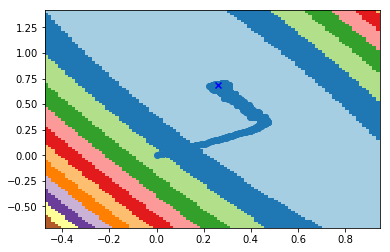

In [144]:
# Cálculo dos limites para gerar o espaço de parâmetros

wmin = w_history.min(axis=1)
wmax = w_history.max(axis=1)
D = wmax - wmin
wmin -= D
wmax += D
print('wmin:', wmin)
print('wmax:', wmax)

# Cálculo da matriz bidimensional de parâmetros
xx, yy = np.meshgrid(np.linspace(wmin[0], wmax[0],100), np.linspace(wmin[1], wmax[1],100))
w_grid = np.c_[xx.ravel(), yy.ravel()].T
print(xx.shape)
print(w_grid.shape)
print(X_bias.shape)

# Cálculo do J(w) para todos os w da matriz de parâmetros

J_grid = compute_cost(X_bias, y, w_grid)

# Plotagem de J na matriz de parâmetros
J_grid = J_grid.reshape(xx.shape)
plt.pcolormesh(xx, yy, J_grid, cmap=plt.cm.Paired)

# Plotagem dos pontos da sequência dos parâmetros durante o processo do gradiente descendente

plt.scatter(w_history[0],w_history[1])
plt.scatter(w_opt[0],w_opt[1],marker='x', c='b') # Solução analítica
plt.show()

## Visualização da Perda x Parâmetros w0,w1 em gráfico 3D

A trecho a seguir permite a visualização da imagem anterior, agora numa superfície tridimensional de modo que para cada par de parâmetro $(w_0,w_1)$ o valor da perda $J(\boldsymbol{w})$ é uma altura da superfície no gráfico.
Sobre esta superfície da função Perda, os valores de $\boldsymbol{w}$ ocorridos durante a busca do
gradiente descendente é mostrado na forma de bolinhas vermelhas. Desta forma é possível acompanhar o caminho que a solução percorre até chegar à solução ótima.

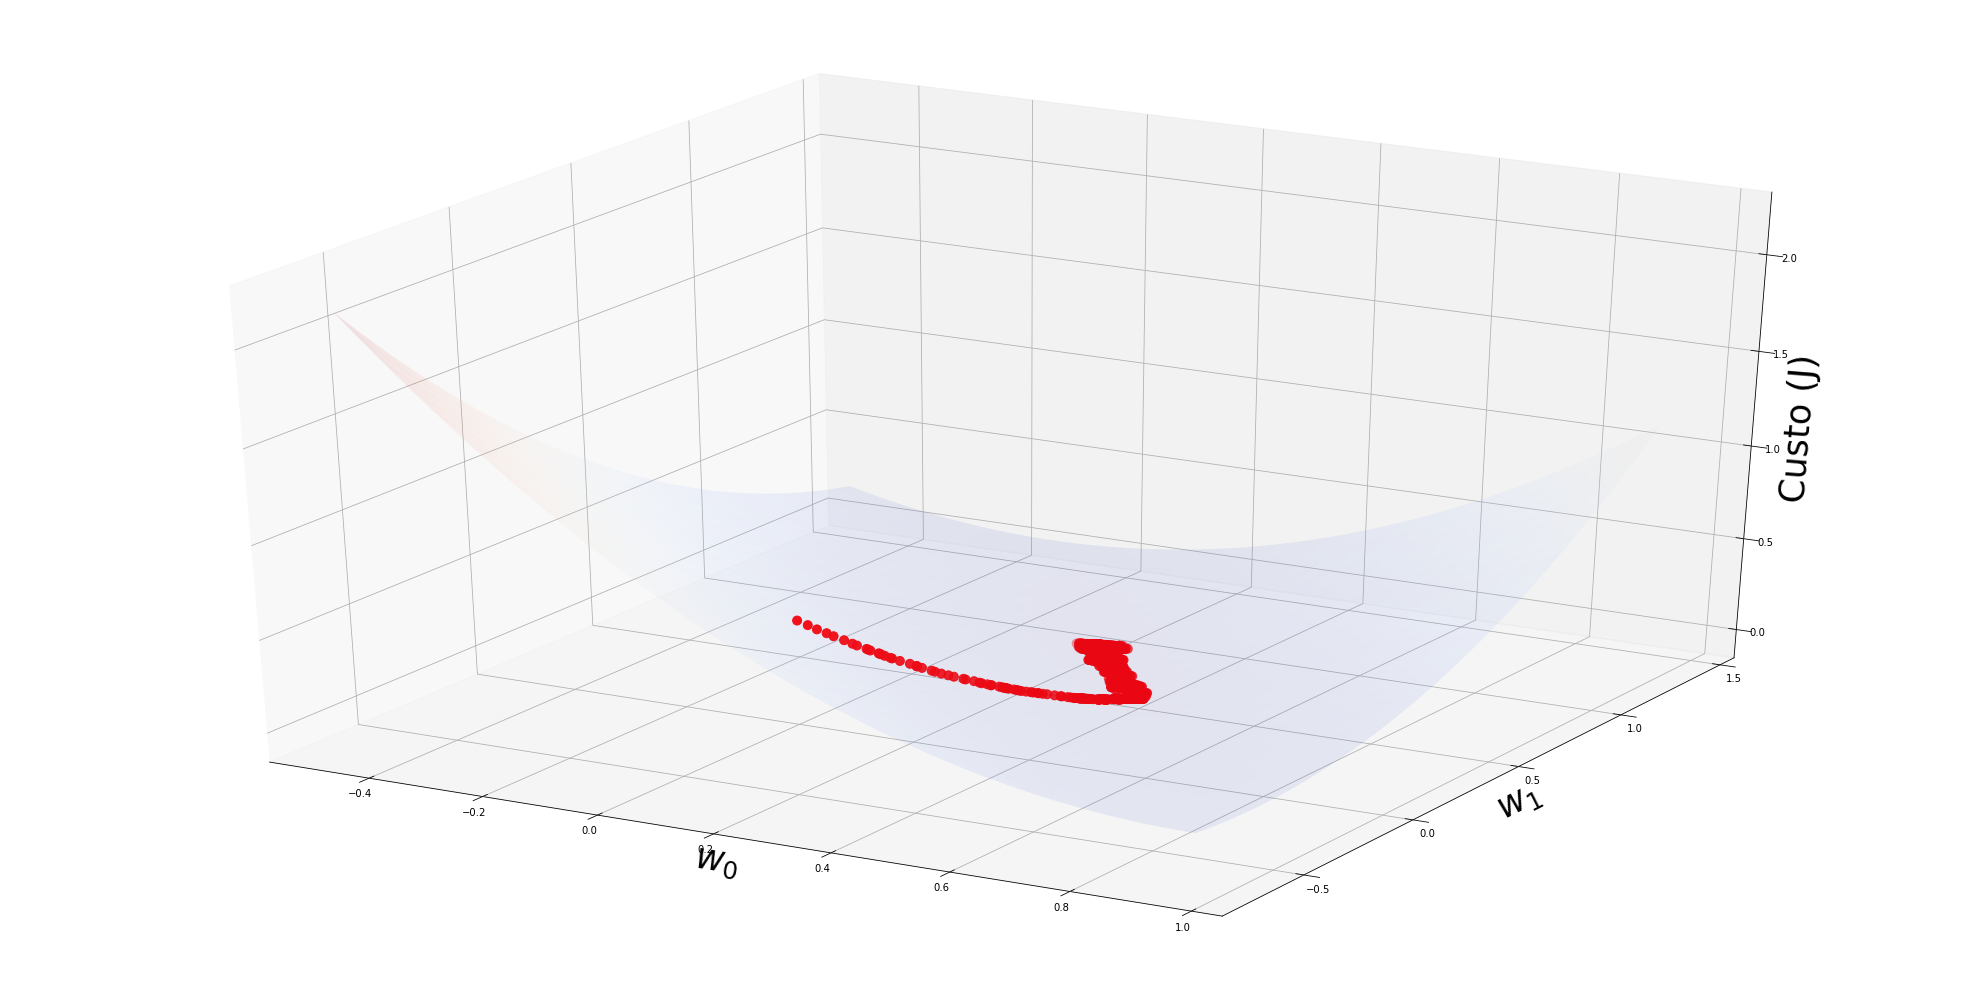

In [145]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


fig = plt.figure(figsize=(35,17.75))
ax = fig.add_subplot(111, projection='3d')

#plota a superfcie 3D
ax.plot_surface(xx, yy, J_grid, rstride=3, cstride=3,  alpha=0.1, cmap=cm.coolwarm)
#Plota o historicos do vetor W
ax.scatter(w_history[0],w_history[1],J_history,c='r',marker = 'o',s = 80)
ax.scatter(w_opt[0],w_opt[1],marker='x', c='b',s = 80)
ax.set_xlabel(r'$w_0$',fontsize = 35)
ax.set_ylabel(r'$w_1$',fontsize = 35)
ax.set_zlabel('Custo (J)',fontsize = 35);

## Fazendo no Keras

In [65]:
import keras
from keras.utils import np_utils 
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.optimizers import SGD

print(keras.__version__)


2.0.3


### Modelo sequencial

A regressão linear pode ser vista como uma rede neural de uma camada e ativação linear (identidade). Assim, é possível implementar a regressão linear no Keras.

A estrutura básica do Keras é o modelo (*model*), a forma mais simples de organizar as camadas da rede neural - apenas uma sequência de camadas. Neste caso será
apenas uma camada básica de rede neural (*Dense*).


In [95]:
model = Sequential() 
model.add(Dense(units=1, input_dim=1, activation='linear',kernel_initializer="zero")) 


### Configurando método de otimização e compilando código para o treinamento

O Keras utilizada a linguagem TensorFlow ou Theano como *backend*. Ambas linguagens são executadas na forma de fluxo. A função
anterior criou o modelo da rede, agora é necessário configurar o otimizador e compilar o modelo para deixá-lo pronto para o
treinamento. O otimizar é o *SGD - Stochastic Gradient Descent*, que quando o tamanho do *batch* for igual ao número de
amostras, o SGD fica equivalente ao *batch gradiente descent*.

In [96]:
sgd = SGD(lr=0.1)
model.compile(optimizer=sgd, loss='mse') 

### Treinamento - batch gradient descent

Uma vez que o modelo foi compilado com o otimizador, o treinamento é feito pelo *fit*, passando os dados de treinamento, número de épocas e o tamanho do batch:

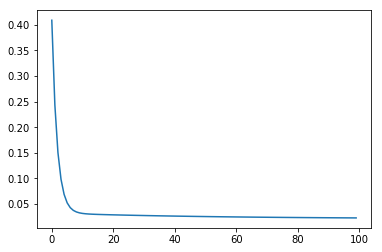

In [97]:
batch_size = 50
nb_epoch = 100
n = x.shape[0] # number of training examples
history = model.fit(x, y, batch_size=batch_size, epochs=nb_epoch,verbose=0)
#print(history.history["loss"][:10])
plt.plot(history.history["loss"]) # mostrando log para amplificar valores baixos
#plt.ylim(0,0.1) # escala máximo y no gráfico 
plt.show()

**Atenção:** Se a célula acima de treinamento for executada novamente, ela continua com o valor do parâmetro já otimizado de sua última execução. Para que o treinamento comece novamente, é preciso executar a inicialização dos parâmetros que ocorre na definição da camada densa.

In [78]:
loss = model.evaluate(x, y, verbose=0)
print('Final loss:',loss)

W = model.get_weights()
print('Bias:\n', W[1])
print('W:\n', W[0])

Final loss: 0.0214245034009
Bias:
 [ 0.29515544]
W:
 [[ 0.62116063]]


## Sugestões de atividades

1. Experimente trocar o número de iterações para bem pouco, 10 iterações e vai aumentando aos poucos. Mostre a perda com o número de iterações. Se for necessário, troque o `ylim` do gráfico para melhor visualização da curva da perda.
2. Troque o valor de $Y$ para gerar as amostras de forma sintética como uma reta, por exemplo, `Y = 2*X`. Qual é o valor ótimo que deve ser encontrado. Veja o que acontece e se o valor converge para o valor ótimo.
3. Varie a taxa de aprendizagem e verifique qual é o valor máximo e mínimo que pode ser utilizado.
4. Retire a normalização que é feita logo após a leitura dos dados e verifique o que acontece.

## Conclusões desse experimento

Quais são as principais conclusões que podemos tirar deste experimento?



## Referências

- [An Introduction to Gradient Descent in Python by Till Bergamann](http://tillbergmann.com/blog/python-gradient-descent.html) Blog, Agosto 2015.
